# SDB Benchmark

## Choices

We took several parameters into account in order to provide unbiased and reproductible results. We present them in the next section.

### Time measurement

In order to measure accurately the time taken for a database CRUD operation to complete, we need to measure the duration between the moment the command is called and the moment it returns (both postgres and cassandra python API functions returns synchronuously). In addition, we measure time by several (100) batches of 100 measurements. This allows to plot the distribution of several latencies AND have precise enough measurements. 
Besides, we use the time.perf_counter function from the time module which has the best accuracy for measuring time in Python.Finally, we also clean the built-in garbage collector of Python before each measurement to ensure consistent behaviour.

### Reproducibility

Most of the queries we generate are random to limit bias in the analysis : one database system could perform surprisingly well for a specific data. Using random queries reduce such a bias. Therefore, we chose to write our queries once to a file and to perform them by reading directly the file instead of generating news random datas at each runtime execution. This let us make precise commentaries on the actual data we have observed which is the very same data you will see being displayed.

## Initialise cassandra database

If the following cells raise a `ConnexionRefuseError`, it may be because of the Cassandra database didn't finished to initialize.

In [1]:
import csv, gc, time
import numpy as np
from matplotlib import pyplot as plt 
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement

In [ ]:
time.sleep(120)

cluster = Cluster(['cassandra'])
session = cluster.connect()

# Create a keyspace and table
session.execute("""CREATE KEYSPACE IF NOT EXISTS benchmarking WITH REPLICATION = 
{ 'class' : 'SimpleStrategy', 'replication_factor' : '1' }""")
session.execute("""CREATE TABLE IF NOT EXISTS benchmarking.bitcoin_addresses (BITCOIN_ADDRESS text, ACCOUNT text, 
IP_ADDRESS text, COUNTY text, COUNTRY_CODE text, DATABASE_COLUMN_TYPE text, PRIMARY KEY 
(BITCOIN_ADDRESS))""")


## Import Data into cassandra

In [10]:
# import data
with open("/home/data.csv", 'r') as file:
    reader = csv.DictReader(file)
    insert_query = session.prepare("""
INSERT INTO benchmarking.bitcoin_addresses (BITCOIN_ADDRESS, ACCOUNT, IP_ADDRESS, COUNTY, COUNTRY_CODE, DATABASE_COLUMN_TYPE)
VALUES (?, ?, ?, ?, ?, ?)
""")
    cassandra_times_import = np.empty(100)

    for sample in range(100):
        batch = BatchStatement()

        for i in range(1000):
            row = next(reader)
            session.execute(insert_query, (
                row['BITCOIN_ADDRESS'],
                row['ACCOUNT'],
                row['IP_ADDRESS'],
                row['COUNTY'],
                row['COUNTRY_CODE'],
                row['DATABASE_COLUMN_TYPE']
            ))

        gc.collect()
        start_time = time.perf_counter()

        session.execute(batch)

        end_time = time.perf_counter()
        cassandra_times_import[sample] = (end_time - start_time)
        print(sample, "%")

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %


In [11]:
print(cassandra_times_import)

[0.00121777 0.00085182 0.00085107 0.00155297 0.00109419 0.00085505
 0.00096572 0.00098491 0.00086205 0.00081848 0.00082834 0.00090398
 0.00093408 0.00086862 0.00090884 0.00134908 0.00095983 0.00088369
 0.00113427 0.00142481 0.00095113 0.00104212 0.00077731 0.00110995
 0.00100252 0.00091248 0.00092553 0.00106597 0.00099421 0.00097742
 0.00082842 0.00085315 0.00088799 0.00074636 0.00083938 0.0007997
 0.00084977 0.00088089 0.0008701  0.00097196 0.00101204 0.00086666
 0.0008023  0.00089075 0.00077896 0.00079138 0.00092745 0.00094079
 0.00107255 0.0009471  0.00095439 0.00088573 0.00085772 0.0008819
 0.00122659 0.00102075 0.00087655 0.00098708 0.00100722 0.00085075
 0.00076765 0.00105927 0.00075692 0.00107505 0.00082204 0.00082126
 0.00079455 0.00093942 0.00082692 0.00100081 0.00083998 0.00078076
 0.00089704 0.00099764 0.00087016 0.00102066 0.0009248  0.00080336
 0.00083273 0.00086806 0.00094337 0.00084828 0.00084497 0.00079347
 0.00089591 0.00087222 0.00093172 0.00099033 0.0007998  0.000892

In [6]:
print("hello world")

hello world


## Initialise PostrgreSQL database

In [6]:
# Connect to the database and set up the table
import psycopg2, random, string
from psycopg2 import sql

connection = psycopg2.connect(
    dbname="postgresDB", 
    user="user", 
    password="tprli", 
    host="postgres",  # Or use your database host if it's not local
    port="5432"  # Default PostgreSQL port
)
connection.autocommit = True
cursor = connection.cursor()


cursor.execute("DROP TABLE IF EXISTS bitcoin_addresses;")

# Step 2: Create the table in PostgreSQL if it doesn't exist
create_table_query = """
CREATE TABLE bitcoin_addresses (
    bitcoin_address VARCHAR(34) NOT NULL, -- Bitcoin addresses are usually 26-35 characters
    account VARCHAR(20),                 -- Account numbers, max length derived from the example
    ip_address VARCHAR(15),              -- IPv4 addresses, formatted as strings
    county VARCHAR(50),                  -- County names, variable length
    country_code CHAR(2),                -- Two-letter country codes
    database_column_type VARCHAR(50),   -- Describes column type as text (e.g., mediumint, float),
    PRIMARY KEY (bitcoin_address)
);
"""
cursor.execute(create_table_query)

## import data into PostgreSQL

In [7]:
postgres_times_import = np.empty(100)
with open('/home/data.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row


    insert_query = """
        INSERT INTO bitcoin_addresses (bitcoin_address, account, ip_address, county, country_code, database_column_type) VALUES (%s, %s, %s, %s, %s, %s)
        """


    for i in range(100):
        gc.collect()
        start_time = time.perf_counter()
        for j in range(1000):
            cursor.execute(insert_query, next(reader))
        end_time = time.perf_counter()
        postgres_times_import[i] = (end_time - start_time)

print("data succesfully imported")

data succesfully imported


In [8]:
print(postgres_times_import)

[2.76684361 2.77289488 2.78181484 2.85278779 2.79091903 2.7933599
 2.73751649 2.76068579 2.74641867 2.78012487 2.98698425 2.88794868
 3.0511889  2.92667969 2.87943665 2.94058218 2.90897973 2.83030669
 2.88741033 2.95940044 2.91999476 2.67064618 2.92406765 2.92707333
 2.90849847 2.96388526 2.87687823 2.97581734 2.98219193 2.87321507
 2.97961245 3.09050853 3.02967527 2.96530243 3.02081624 2.9474481
 2.88513389 2.94830955 2.97577726 2.99537598 2.94271401 2.95462815
 3.01921307 2.99226257 2.94501223 3.008426   3.09710562 3.03367555
 3.00084071 2.84983545 3.09145163 2.99994907 2.90720479 2.85314563
 3.10752784 2.87047316 2.84954142 2.86831802 2.85818652 2.87438592
 2.87999406 2.78428042 2.85906615 2.86040405 2.89710057 2.80273203
 2.68806433 2.88976915 2.87932844 2.77543646 2.93740499 2.96824589
 2.9467565  2.93920347 3.08987975 3.05006303 3.05612843 2.90929236
 2.97171879 2.94244589 2.99464978 2.90130883 3.02325515 3.00090979
 2.904394   3.02400276 2.94345826 2.9184221  2.90487008 2.888364

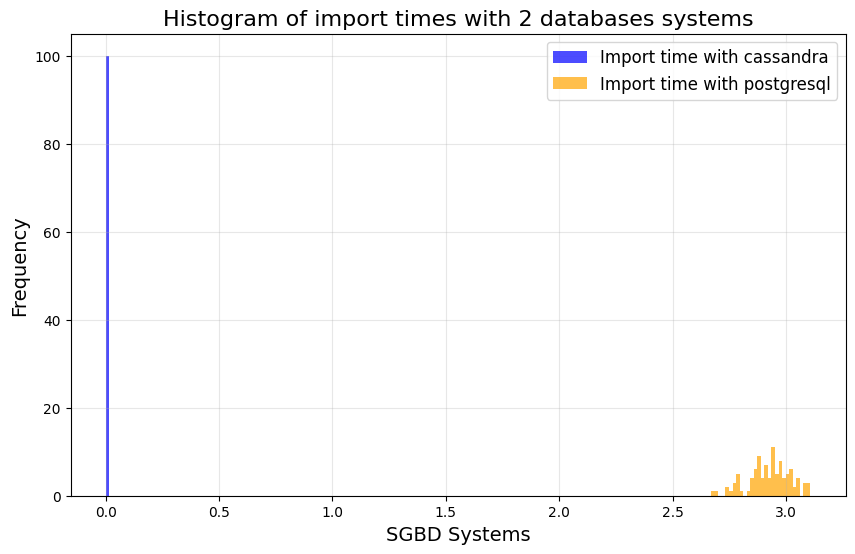

In [13]:
import numpy as np
import matplotlib.pyplot as plt

min_bin = min(cassandra_times_import.min(), postgres_times_import.min())
max_bin = max(cassandra_times_import.max(), postgres_times_import.max())
bins = np.linspace(min_bin, max_bin, 200)  # 20 bins entre les valeurs min et max

# Création de l'histogramme avec des bornes communes
plt.figure(figsize=(10, 6))
plt.hist(cassandra_times_import, bins=bins, alpha=0.7, label='Cassandra', color='blue')
plt.hist(postgres_times_import, bins=bins, alpha=0.7, label='Postgresql', color='orange')

# Ajout des légendes et des titres
plt.title('Histogram of import times with 2 databases systems', fontsize=16)
plt.xlabel('SGBD Systems', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Affichage
plt.show()

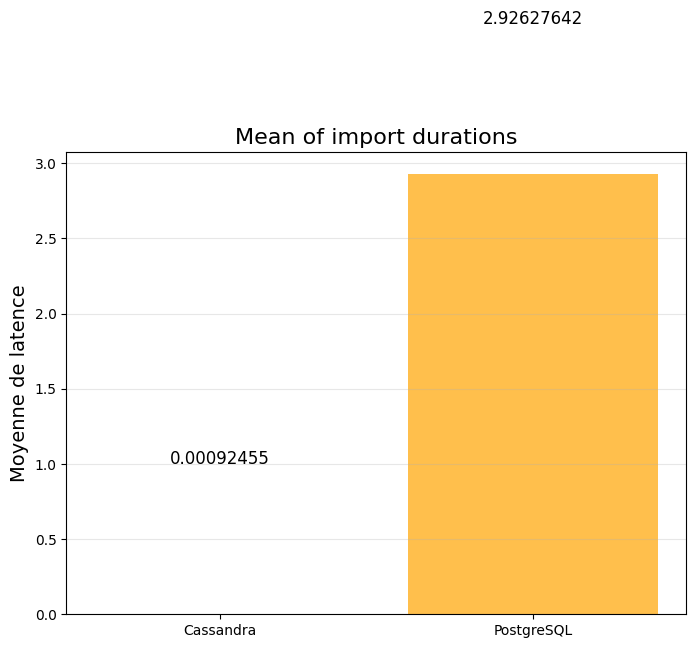

In [17]:
moyenne1 = np.mean(cassandra_times_import)
moyenne2 = np.mean(postgres_times_import)

labels = ['Cassandra', 'PostgreSQL']
moyennes = [moyenne1, moyenne2]

# Création du graphique en barres
plt.figure(figsize=(8, 6))
plt.bar(labels, moyennes, color=['blue', 'orange'], alpha=0.7)

# Ajout des annotations
for i, moyenne in enumerate(moyennes):
    plt.text(i, moyenne + 1, f'{moyenne:.8f}', ha='center', fontsize=12)

# Ajout des titres et légendes
plt.title('Mean of import durations', fontsize=16)
plt.ylabel('Moyenne de latence', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Affichage
plt.show()

## Requests Generation

Generation of randomized queries

In [25]:
import random
# Generate random requests
simulated_values = {
    'BITCOIN_ADDRESS': lambda: f"'{''.join(random.choices('ABCDEFGHJKLMNPQRSTUVWXYZ123456789', k=32))}'",
    'ACCOUNT': lambda: f"'{random.randint(10000000, 99999999)}'",
    'IP_ADDRESS': lambda: f"'{random.randint(1, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(1, 255)}'",
    'COUNTY': lambda: f"'{random.choice(['Buckinghamshire', 'Avon', 'Cambridgeshire', 'Bedfordshire', 'Borders'])}'",
    'COUNTRY_CODE': lambda: f"'{random.choice('ABCDEFGHJKLMNPQRSTUVWXYZ')}{random.choice('ABCDEFGHJKLMNPQRSTUVWXYZ')}'",
    'DATABASE_COLUMN_TYPE': lambda: f"'{random.choice(['float', 'point', 'int', 'serial', 'varchar', 'blob', 'timestamp'])}'"
}
def generate_random_select_primary_key(table_name, primary_key, set_of_primary_key_values):
    primary_key_value = random.choice(set_of_primary_key_values)

    select_query = f"SELECT * FROM {table_name} WHERE {primary_key} = '{primary_key_value}'"
    return select_query

def generate_random_select_conditions(tables_name, column_names):
    column = random.choice(column_names)

    value = simulated_values[column]()  # Générer une valeur simulée pour la colonne
    where_clause = f"WHERE {column} = {value}"

    select_queries = {}
    for table in tables_name:
        select_queries[table] = f"SELECT {column} FROM {table} {where_clause}"
    return select_queries

def generate_random_update_query(table_name, column_names, primary_key, set_of_primary_key_values):
    num_updates = random.randint(1,3)
    columns_to_update = random.sample(column_names, num_updates)
    update_values = [f"{col} = {simulated_values[col]()}" for col in columns_to_update]

    primary_key_value = random.choice(set_of_primary_key_values)

    update_query = f"UPDATE {table_name} SET {', '.join(update_values)} WHERE {primary_key} = '{primary_key_value}'"
    return update_query

def generate_random_delete_query(table_name, primary_key, set_of_primary_key_values):
    primary_key_value = random.choice(set_of_primary_key_values)

    delete_query = f"DELETE FROM {table_name} WHERE {primary_key} = '{primary_key_value}'"
    return delete_query

table = "bitcoin_addresses"
table_indexed = "bitcoin_addresses_indexed"
table_not_indexed = "bitcoin_addresses_not_indexed"
conditions_column = ['COUNTY', 'COUNTRY_CODE','DATABASE_COLUMN_TYPE']
update_column = ['ACCOUNT', 'IP_ADDRESS', 'COUNTY', 'COUNTRY_CODE', 'DATABASE_COLUMN_TYPE']
primary_key = 'BITCOIN_ADDRESS'
set_of_key = []
rows = session.execute("SELECT BITCOIN_ADDRESS FROM benchmarking.bitcoin_addresses")
for a in rows:
    set_of_key.append(a[0])

# Generate Select queries to match primary key
with open("select_primary_key.sql", "w") as f:
    for i in range(10000):
        f.write(generate_random_select_primary_key(table, primary_key, set_of_key))
        f.write("\n")
    f.close()
    
# Generate Select with conditions queries
with  open("select_conditions_not_indexed.sql", "w") as f, open("select_conditions_indexed_0.sql", "w") as f_index_table:
    for i in range(100):
        queries = generate_random_select_conditions([table_not_indexed, table_indexed], conditions_column)
        f.write(queries[table_not_indexed])
        f.write("\n")
        f_index_table.write(queries[table_indexed])
        f_index_table.write("\n")
    f.close()

# Generate Update queries
with open("update.sql", "w") as f:
    for i in range(10000):
        f.write(generate_random_update_query(table, update_column, primary_key, set_of_key))
        f.write("\n")
    f.close()

# Generate Delete queries
with open("delete.sql", "w") as f:
    for i in range(10000):
        f.write(generate_random_delete_query(table, primary_key, set_of_key))
        f.write("\n")
    f.close()

## Queries Benchmarking

### Select

#### Cassandra

In [3]:
# Benchmark SELECT
session.set_keyspace("benchmarking")

select_path = "select_primary_key_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    cassandra_times_select = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            session.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        cassandra_times_select[i] = (end_time - start_time)

print(cassandra_times_select)

[0.43874113 0.37989223 0.33858067 0.29878068 0.27673291 0.24575746
 0.292858   0.30266506 0.2323254  0.23325105 0.24408097 0.24500588
 0.20215337 0.19970992 0.20391004 0.20292758 0.22810172 0.27385431
 0.2069418  0.2909687  0.22890486 0.22963674 0.21844871 0.24148413
 0.25541651 0.2528514  0.20961406 0.19951056 0.20267317 0.35755599
 0.25382356 0.20386967 0.21156321 0.27448104 0.19859918 0.19719873
 0.26954562 0.23030601 0.25107259 0.26552258 0.26017314 0.33925846
 0.36031712 0.35853156 0.37397215 0.342017   0.3238001  0.21860206
 0.18610526 0.32732968 0.22669328 0.20042109 0.18086852 0.23190277
 0.2895016  0.25182971 0.21926486 0.19046205 0.26356155 0.22101157
 0.19185475 0.18469695 0.18265054 0.21011393 0.18724921 0.18059618
 0.24628831 0.27947003 0.18864014 0.1823335  0.18163694 0.20803976
 0.16941817 0.17492761 0.16192578 0.16260677 0.16149426 0.16851392
 0.16070112 0.17248387 0.16839155 0.16352602 0.15934213 0.17065651
 0.15939998 0.16530205 0.15406211 0.16854222 0.14773054 0.1618

#### PostgreSQL

In [20]:
select_path = "select_primary_key_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    postgres_times_select = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            cursor.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        postgres_times_select[i] = (end_time - start_time)
print(postgres_times_select)

[0.02480564 0.02151742 0.02193831 0.02305975 0.01924432 0.01974552
 0.02092553 0.01738784 0.01999947 0.01766379 0.01979448 0.01877473
 0.01863107 0.01998674 0.02059031 0.01879533 0.02007763 0.0183402
 0.02037129 0.01957651 0.01949073 0.0194543  0.0205829  0.01916042
 0.02222362 0.01984615 0.02226696 0.02047857 0.01872544 0.01785005
 0.02198793 0.0191772  0.01883298 0.01806171 0.0251184  0.02445628
 0.02267849 0.02509458 0.02397507 0.02080402 0.01993398 0.01746025
 0.01875643 0.0185785  0.01695288 0.02007395 0.01684668 0.01864678
 0.02041515 0.01874851 0.02047555 0.01883266 0.01879681 0.01961488
 0.02110305 0.01924047 0.02230688 0.01917352 0.0166588  0.01878024
 0.01719789 0.01786752 0.01858051 0.01619423 0.01659606 0.01835661
 0.0175684  0.01827592 0.01785903 0.01533304 0.01462106 0.01735745
 0.02057479 0.02384888 0.01959505 0.02262203 0.02058192 0.02322728
 0.01872196 0.01807875 0.02227546 0.02284972 0.02614527 0.01966631
 0.01841423 0.02017714 0.01798148 0.01704343 0.01693119 0.02092

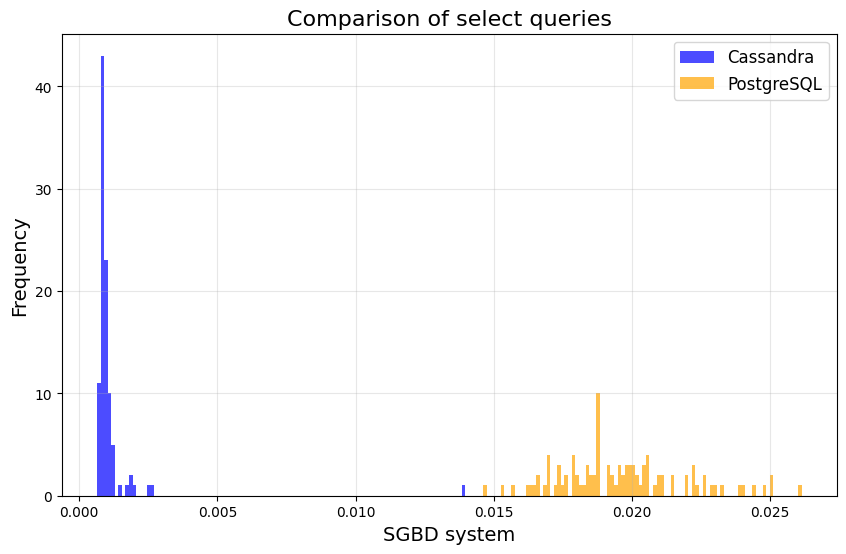

In [21]:
min_bin = min(cassandra_times_select.min(), postgres_times_select.min())
max_bin = max(cassandra_times_select.max(), postgres_times_select.max())
bins = np.linspace(min_bin, max_bin, 200)  # 20 bins entre les valeurs min et max

# Création de l'histogramme avec des bornes communes
plt.figure(figsize=(10, 6))
plt.hist(cassandra_times_select, bins=bins, alpha=0.7, label='Cassandra', color='blue')
plt.hist(postgres_times_select, bins=bins, alpha=0.7, label='PostgreSQL', color='orange')

# Ajout des légendes et des titres
plt.title('Comparison of select queries', fontsize=16)
plt.xlabel('SGBD system', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Affichage
plt.show()

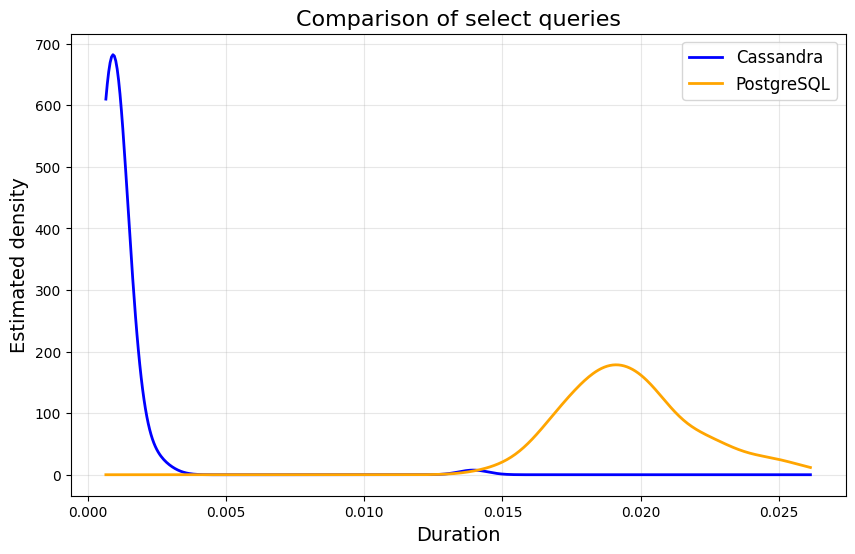

In [23]:
from scipy.stats import gaussian_kde

# Estimation de la densité pour chaque ensemble de données
x = np.linspace(min(cassandra_times_select.min(), postgres_times_select.min()), 
                max(cassandra_times_select.max(), postgres_times_select.max()), 500)
density1 = gaussian_kde(cassandra_times_select)
density2 = gaussian_kde(postgres_times_select)

# Tracer les enveloppes des courbes de densité
plt.figure(figsize=(10, 6))
plt.plot(x, density1(x), label='Cassandra', color='blue', linewidth=2)
plt.plot(x, density2(x), label='PostgreSQL', color='orange', linewidth=2)

# Ajout des légendes et des titres
plt.title('Comparison of select queries', fontsize=16)
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Estimated density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Affichage
plt.show()

### Update

#### Cassandra

In [24]:
# Benchmark Update
session.set_keyspace("benchmarking")

select_path = "update_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    cassandra_times_update = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            session.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        cassandra_times_update[i] = (end_time - start_time)
print(cassandra_times_update)

[0.20722852 0.16326704 0.11891919 0.12432801 0.11042166 0.09433536
 0.08821225 0.13311429 0.11737467 0.09828496 0.08452447 0.08767238
 0.08734196 0.0894627  0.12736801 0.08662136 0.08238709 0.09770533
 0.08383116 0.07489045 0.09312593 0.08605911 0.11642301 0.11975347
 0.12011157 0.10884035 0.08292707 0.08544286 0.08041329 0.08014513
 0.105599   0.10937886 0.08211772 0.07138084 0.07192363 0.07232273
 0.0716463  0.07590956 0.08439559 0.07339023 0.08704854 0.09696953
 0.10509071 0.08020421 0.07397726 0.08471212 0.07616632 0.07514483
 0.08144674 0.08261133 0.08637601 0.07991553 0.08572419 0.07814776
 0.08121888 0.10729723 0.12389514 0.10755225 0.07879911 0.08800541
 0.12292493 0.09013603 0.08044506 0.07496275 0.07314431 0.08029031
 0.07195496 0.07006654 0.06489425 0.09581078 0.09605448 0.1020516
 0.09329539 0.12207347 0.11633206 0.11378626 0.06026732 0.06291999
 0.06194618 0.0712025  0.06332229 0.07120985 0.07866612 0.10195061
 0.07695131 0.06802636 0.10226518 0.08435938 0.08357464 0.09801

#### PostgreSQL

In [16]:
select_path = "update_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    postgres_times_update = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            cursor.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        postgres_times_update[i] = (end_time - start_time)
print(postgres_times_update)

[0.29388257 0.29892262 0.32443757 0.3074198  0.34650437 0.31036492
 0.28986158 0.29686505 0.28439015 0.28093685 0.28848593 0.31499116
 0.27437826 0.28518372 0.26942235 0.2882191  0.29728232 0.2882132
 0.28372269 0.30827102 0.29241546 0.30478228 0.29124543 0.29900844
 0.32450333 0.28125489 0.32509846 0.28933875 0.28818746 0.31289081
 0.29145352 0.3156575  0.33226023 0.29029803 0.30746566 0.33682401
 0.30628587 0.29688949 0.28833459 0.30904901 0.32005847 0.30342533
 0.31282409 0.30375765 0.29328468 0.30591801 0.30759167 0.3170452
 0.28611476 0.28588328 0.29869665 0.35995351 0.3042521  0.29431377
 0.32320556 0.30606756 0.28883973 0.30733171 0.28531482 0.32591698
 0.29045636 0.29955946 0.292605   0.30148204 0.29919359 0.30929034
 0.27847579 0.31997614 0.28189325 0.31604105 0.31350344 0.31494874
 0.31628916 0.30306246 0.29197294 0.3036214  0.32436891 0.31090389
 0.30104167 0.28192033 0.29616123 0.28355905 0.31709184 0.28268095
 0.31309422 0.32166385 0.35387934 0.30670334 0.33210591 0.317862

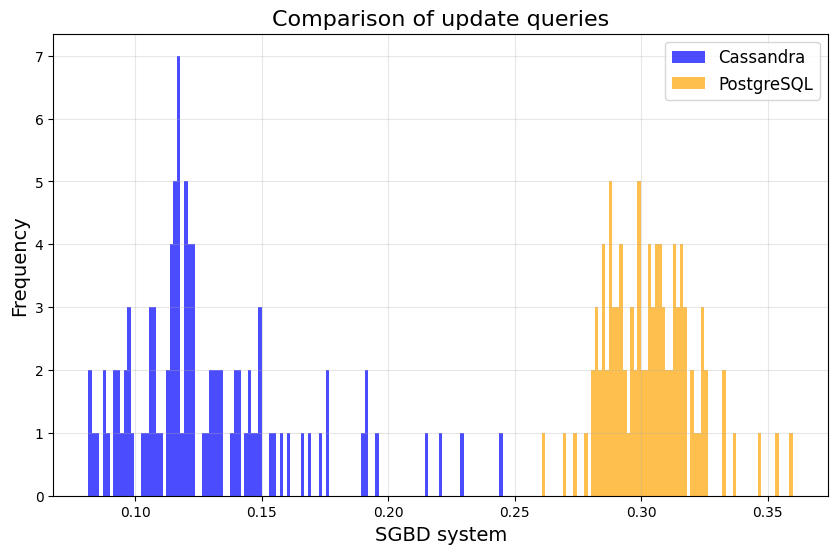

In [17]:
min_bin = min(cassandra_times_update.min(), postgres_times_update.min())
max_bin = max(cassandra_times_update.max(), postgres_times_update.max())
bins = np.linspace(min_bin, max_bin, 200)  # 20 bins entre les valeurs min et max

# Création de l'histogramme avec des bornes communes
plt.figure(figsize=(10, 6))
plt.hist(cassandra_times_update, bins=bins, alpha=0.7, label='Cassandra', color='blue')
plt.hist(postgres_times_update, bins=bins, alpha=0.7, label='PostgreSQL', color='orange')

# Ajout des légendes et des titres
plt.title('Comparison of update queries', fontsize=16)
plt.xlabel('SGBD system', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Affichage
plt.show()

### Delete

#### Cassandra

In [25]:
# Benchmark DELETE
session.set_keyspace("benchmarking")

select_path = "delete_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    cassandra_times_delete = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            session.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        cassandra_times_delete[i] = (end_time - start_time)
print(cassandra_times_delete)

[0.12336761 0.16021472 0.07601968 0.06650211 0.06365852 0.08768926
 0.0910511  0.08075962 0.07274155 0.06512468 0.06929542 0.06409452
 0.06652839 0.0611498  0.08967191 0.06469739 0.06148557 0.05979684
 0.07109833 0.0693656  0.0681473  0.06369813 0.0668856  0.06810074
 0.06448166 0.05921534 0.06001751 0.05961664 0.06186127 0.06316342
 0.06102057 0.07530718 0.06118373 0.06407812 0.07974484 0.07689265
 0.11406165 0.09963257 0.08004645 0.07899334 0.06279894 0.06851901
 0.08025423 0.06350349 0.08005582 0.07580818 0.07511129 0.06202842
 0.0593858  0.0599523  0.07362639 0.06998092 0.05842448 0.06174335
 0.09404031 0.0573051  0.05801817 0.05805921 0.0593031  0.06050844
 0.07812286 0.07230716 0.06942142 0.07042228 0.06213461 0.07084792
 0.07072247 0.06664912 0.05836639 0.08382768 0.07965755 0.06443803
 0.0627834  0.05740659 0.06253663 0.06527182 0.05765091 0.05813034
 0.05805162 0.07953797 0.05945754 0.06046134 0.05816552 0.07411714
 0.07970891 0.07662429 0.06237986 0.0655732  0.05994163 0.0589

#### PostgreSQL

In [26]:
# Benchmark DELETE
session.set_keyspace("benchmarking")

select_path = "delete_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    postgres_times_delete = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            cursor.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        postgres_times_delete[i] = (end_time - start_time)
print(postgres_times_delete)

[0.30793712 0.31654004 0.308613   0.30049702 0.28583865 0.28918724
 0.27753543 0.27270449 0.30267778 0.2743729  0.29711182 0.29390862
 0.32560635 0.2750635  0.30545953 0.2940431  0.29862526 0.28865023
 0.2875853  0.30055082 0.29493571 0.29641933 0.29891072 0.28436348
 0.28296548 0.29298905 0.27082883 0.26373306 0.29280569 0.29349941
 0.30805828 0.29202671 0.29045858 0.29942354 0.29710877 0.29043029
 0.30060409 0.27795838 0.28459427 0.27904061 0.27670141 0.27936462
 0.26879475 0.28586969 0.29709696 0.29022125 0.28124623 0.27640555
 0.28840532 0.27891166 0.28979401 0.28195394 0.29762162 0.28906345
 0.27162385 0.24817252 0.28557043 0.28760969 0.28273177 0.26268205
 0.29989953 0.26537412 0.30508191 0.32115136 0.32944524 0.32618788
 0.28698292 0.27308702 0.27329452 0.28286281 0.29319071 0.28526518
 0.24552787 0.29748969 0.28750954 0.29371439 0.29220066 0.26801542
 0.29508825 0.27205199 0.28293999 0.25419371 0.29578857 0.24423344
 0.26314878 0.28671057 0.27543581 0.25693995 0.24601742 0.2930

In [ ]:
min_bin = min(cassandra_times_delete.min(), postgres_times_delete.min())
max_bin = max(cassandra_times_delete.max(), postgres_times_delete.max())
bins = np.linspace(min_bin, max_bin, 200)  # 20 bins entre les valeurs min et max

# Création de l'histogramme avec des bornes communes
plt.figure(figsize=(10, 6))
plt.hist(cassandra_times_delete, bins=bins, alpha=0.7, label='Cassandra', color='blue')
plt.hist(postgres_times_delete, bins=bins, alpha=0.7, label='PostgreSQL', color='orange')

# Ajout des légendes et des titres
plt.title('Comparison of delete queries', fontsize=16)
plt.xlabel('SGBD system', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Affichage
plt.show()

## Index utilisation

Set up new table to benchmark effect of indexing.

In [14]:
# Create two tables to compare 
session.execute("""CREATE TABLE IF NOT EXISTS benchmarking.bitcoin_addresses_not_indexed (BITCOIN_ADDRESS text, ACCOUNT text, 
IP_ADDRESS text, COUNTY text, COUNTRY_CODE text, DATABASE_COLUMN_TYPE text, PRIMARY KEY 
(BITCOIN_ADDRESS))""")
session.execute("""CREATE TABLE IF NOT EXISTS benchmarking.bitcoin_addresses_indexed (BITCOIN_ADDRESS text, ACCOUNT text, 
IP_ADDRESS text, COUNTY text, COUNTRY_CODE text, DATABASE_COLUMN_TYPE text, PRIMARY KEY 
(BITCOIN_ADDRESS))""")

# Import data
with open("/home/data.csv", 'r') as file:
    reader = csv.DictReader(file)
    indexed_insert_query = session.prepare("""
INSERT INTO benchmarking.bitcoin_addresses_not_indexed (BITCOIN_ADDRESS, ACCOUNT, IP_ADDRESS, COUNTY, COUNTRY_CODE, DATABASE_COLUMN_TYPE)
VALUES (?, ?, ?, ?, ?, ?)
""")
    notindexed_insert_query = session.prepare("""
INSERT INTO benchmarking.bitcoin_addresses_indexed (BITCOIN_ADDRESS, ACCOUNT, IP_ADDRESS, COUNTY, COUNTRY_CODE, DATABASE_COLUMN_TYPE)
VALUES (?, ?, ?, ?, ?, ?)
""")

    batch = BatchStatement()

    for row in reader:
        session.execute(indexed_insert_query, (
            row['BITCOIN_ADDRESS'],
            row['ACCOUNT'],
            row['IP_ADDRESS'],
            row['COUNTY'],
            row['COUNTRY_CODE'],
            row['DATABASE_COLUMN_TYPE']
        ))
        session.execute(notindexed_insert_query, (
            row['BITCOIN_ADDRESS'],
            row['ACCOUNT'],
            row['IP_ADDRESS'],
            row['COUNTY'],
            row['COUNTRY_CODE'],
            row['DATABASE_COLUMN_TYPE']
        ))

    session.execute(batch)

**Creation of an index**

`COUNTY` `COUNTRY_CODE` `DATABASE_COLUMN_TYPE` columns are selected to be indexed because they have a moderate cardinality. The indexing must have a significant effect on queries performances.

In [15]:

# Create index
create_index_query_county = """CREATE INDEX IF NOT EXISTS countyindex on benchmarking.bitcoin_addresses_indexed (COUNTY)"""
session.execute(create_index_query_county)
create_index_query_countrycode = """CREATE INDEX IF NOT EXISTS countrycodeindex on benchmarking.bitcoin_addresses_indexed (COUNTRY_CODE)"""
session.execute(create_index_query_countrycode)
create_index_query_datacolumntype = """CREATE INDEX IF NOT EXISTS datacolumntypeindex on benchmarking.bitcoin_addresses_indexed (DATABASE_COLUMN_TYPE)"""
session.execute(create_index_query_datacolumntype)

#### Queries with conditions
To evaluate the performance of indexing, we perform SELECT queries with where clause on indexed columns.

**Indexed table**

In [34]:
# Benchmark indexed table
session.set_keyspace("benchmarking")

select_path = "select_conditions_indexed_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = len(lines)
    cassandra_times_select_indexed = np.empty(n_iter)
    
    for line in lines:
        gc.collect()
        start_time = time.perf_counter()

        session.execute(line)

        end_time = time.perf_counter()
        cassandra_times_select_indexed[i] = (end_time - start_time)

**Not indexed table**

In [ ]:
# Benchmark not indexed table
session.set_keyspace("benchmarking")

select_path = "select_conditions_not_indexed_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = len(lines)
    cassandra_times_select_not_indexed = np.empty(n_iter)
    for i in range(n_iter):
        lines[i] = f"{lines[i][:-1]} ALLOW FILTERING"
    
    for line in lines:
        gc.collect()
        start_time = time.perf_counter()

        session.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        cassandra_times_select_not_indexed[i] = (end_time - start_time)

## Replication performances benchmarking

**Setup replication**

In [2]:
cluster_replicate = Cluster(['cassandra-replicat-0'])
session_replicate = cluster_replicate.connect()

# Create keyspace with replication
session_replicate.execute("""CREATE KEYSPACE IF NOT EXISTS benchmarking WITH REPLICATION = 
{ 'class' : 'SimpleStrategy', 'replication_factor' : '3' }""")

# Create table
session_replicate.execute("""CREATE TABLE IF NOT EXISTS benchmarking.bitcoin_addresses (BITCOIN_ADDRESS text, ACCOUNT text, 
IP_ADDRESS text, COUNTY text, COUNTRY_CODE text, DATABASE_COLUMN_TYPE text, PRIMARY KEY 
(BITCOIN_ADDRESS))""")

**Import Data**

In [3]:
# Import data
with open("/home/data.csv", 'r') as file:
    reader = csv.DictReader(file)
    insert_query = session_replicate.prepare("""
INSERT INTO benchmarking.bitcoin_addresses (BITCOIN_ADDRESS, ACCOUNT, IP_ADDRESS, COUNTY, COUNTRY_CODE, DATABASE_COLUMN_TYPE)
VALUES (?, ?, ?, ?, ?, ?)
""")
    cassandra_replication_times_import = np.empty(100)

    for sample in range(100):
        batch = BatchStatement()

        for i in range(1000):
            row = next(reader)
            session_replicate.execute(insert_query, (
                row['BITCOIN_ADDRESS'],
                row['ACCOUNT'],
                row['IP_ADDRESS'],
                row['COUNTY'],
                row['COUNTRY_CODE'],
                row['DATABASE_COLUMN_TYPE']
            ))

        gc.collect()
        start_time = time.perf_counter()

        session_replicate.execute(batch)

        end_time = time.perf_counter()
        cassandra_replication_times_import[sample] = (end_time - start_time)
        print(sample, "%")

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %


**SELECT**

In [4]:
# Benchmark SELECT
session_replicate.set_keyspace("benchmarking")

select_path = "select_primary_key_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    cassandra_replicate_times_select = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            session_replicate.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        cassandra_replicate_times_select[i] = (end_time - start_time)

**UPDATE**

In [5]:
# Benchmark DELETE
session_replicate.set_keyspace("benchmarking")

select_path = "update_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    cassandra_replicate_times_update = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            session_replicate.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        cassandra_replicate_times_update[i] = (end_time - start_time)

**Delete**

In [6]:
# Benchmark DELETE
session_replicate.set_keyspace("benchmarking")

select_path = "delete_0.sql"
with open(select_path, "r") as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    cassandra_replicate_times_delete = np.empty(n_iter)
    
    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()

        for j in range(100):
            session_replicate.execute(lines[i*100 + j])

        end_time = time.perf_counter()
        cassandra_replicate_times_delete[i] = (end_time - start_time)